In [22]:
import os
import glob
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

from PIL import Image

classes = ['mask', 'no_mask']

dim = 64
batch_size = 32
step_per_epoch = 10000//batch_size
epoch = 10

In [23]:
def read_img(file):
    img = tf.io.read_file(file)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([None,None,3])
    img = tf.image.resize(img, [dim, dim])
    img = img/127.5-1
    return img

def load_set(path):
    mask_path = path + '/WithMask' + '/*.png'
    no_mask_path = path + '/WithoutMask' + '/*.png'
    img_list = []
    label_list = []
    for filename in glob.glob(mask_path): 
        img_list.append(read_img(filename))
    label_list += [0] * len(img_list)
    masked_len = len(img_list)
    
    for filename in glob.glob(no_mask_path):
        img_list.append(read_img(filename))
    label_list += [1] * (len(img_list) - masked_len)

    #shuffle
    temp = list(zip(img_list, label_list)) 
    random.shuffle(temp) 
    img_list, label_list = zip(*temp) 
    
    return list(img_list), list(label_list)

#Load Kaggle Dataset 
[training_img, training_labels] = load_set('../kaggle_12k/Train')
[validation_img, validation_labels] = load_set('../kaggle_12k/Validation')
[test_img, test_labels] = load_set('../kaggle_12k/Test')
    

In [24]:
#From Tanya
def data_generator(features,labels):
  dataset = tf.data.Dataset.from_tensor_slices((features,labels))
  dataset = dataset.shuffle(buffer_size=100)
  autotune = tf.data.experimental.AUTOTUNE
  #dataset = dataset.map(load_data, num_parallel_calls=autotune)
  dataset = dataset.batch(batch_size=batch_size)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(autotune)
  return dataset

In [25]:
train_dataset = data_generator(training_img, training_labels)


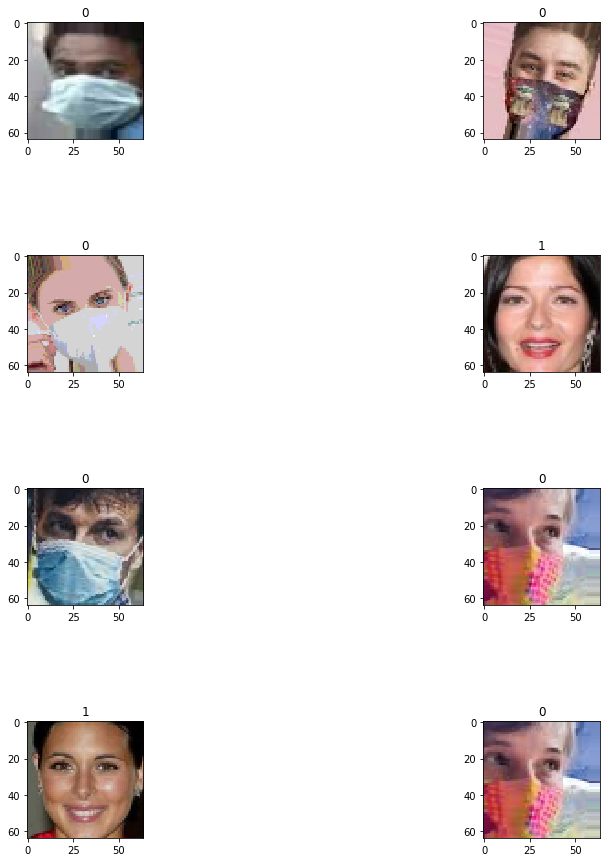

In [26]:
#Also Tanya
def show_img(dataset):
  plt.figure(figsize=(15,15))
  for i in range(8):
    for val in dataset.take(1):
      img  = (val[0][i]+1)*127.5
      plt.subplot(4,2,i+1)
      plt.imshow(tf.cast(img,tf.uint8))
      plt.title(val[1][i].numpy())
      plt.subplots_adjust(hspace=1)
  plt.show()

show_img(train_dataset)

In [27]:
def conv_model(num_blocks, rate, dim):
    
    input = tf.keras.layers.Input(shape=(dim,dim,3))
    
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=2, strides=1)(input)
    x = tf.keras.layers.Dropout(rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters=2, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    predictions = tf.keras.layers.Activation('softmax')(x)
    
    model = tf.keras.Model(inputs=input, outputs=predictions)
    print(model.summary())
    
    return model


In [28]:
model = conv_model(0,.1, dim)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('mask_classification_model.h5', 
                                       save_best_only=True, 
                                       save_weights_only=True,
                                       monitor='loss')]

model.fit(train_dataset,
          batch_size=batch_size,
          epochs=epoch,steps_per_epoch=step_per_epoch,
          callbacks=callbacks)

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 63, 63, 16)        208       
_________________________________________________________________
dropout_14 (Dropout)         (None, 63, 63, 16)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 63, 63, 16)        64        
_________________________________________________________________
activation_13 (Activation)   (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 63, 63, 2)         34        
_________________________________________________________________
dropout_15 (Dropout)         (None, 63, 63, 2)       

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node functional_13/conv2d_14/Conv2D (defined at <ipython-input-28-be597505abad>:15) ]] [Op:__inference_train_function_924711]

Function call stack:
train_function
